In [1]:
import numpy as np
from transformers import pipeline
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from newsapi import NewsApiClient
from datetime import date
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import yfinance as yf
from arch import arch_model
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
load_dotenv()
import os

C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("datasets/original/TSLA.csv")

# Extract relevant columns
predicted_prices = np.array(df["RF_Prediction"])
volatility_features = np.array(df["Weekly_Volatility"])
sentiment_scores = np.array(df["Weekly_Sentiment"])

In [3]:
label_encoder = LabelEncoder()
df["Trend"] = label_encoder.fit_transform(df["Trend"])
actual_trend = np.array(df["Trend"])

In [4]:
class MarketEnv:
    def __init__(self, predicted_prices, volatility_features, news_data, actual_trend):
        self.predicted_prices = predicted_prices
        self.volatility_features = volatility_features
        self.news_data = np.array(news_data)
        self.actual_trend = actual_trend
        self.index = 0
        self.done = False

    def get_state(self):
        if self.index >= len(self.predicted_prices):
            self.done = True
            return None
        
        sentiment = np.array([self.news_data[self.index % len(self.news_data)]])
        predicted_price = np.array([self.predicted_prices[self.index]])
        volatility = np.array([self.volatility_features[self.index]])
        
        self.index += 1
        return np.concatenate([sentiment, predicted_price, volatility])

    def reset(self):
        self.index = 0
        self.done = False
        return self.get_state()

    def step(self, action):
        current_index = min(self.index - 1, len(self.actual_trend) - 1)
        true_trend = self.actual_trend[current_index % len(self.actual_trend)]  # Use modulo to cycle through trends
        
        # Reward based on action correctness
        reward = 1 if action == true_trend else -0.1  # Smaller penalty
        next_state = self.get_state()
        return next_state, reward, self.done

# Initialize environment with the fetched data

env = MarketEnv(predicted_prices, volatility_features, sentiment_scores, actual_trend)


In [5]:
state_bins = 10  # Number of bins for each state dimension
state_dims = len(env.get_state())  # Get number of state dimensions
q_table = np.random.uniform(low=-1, high=1, size=(state_bins ** state_dims, 2))  # Random initialization

alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate

In [6]:
def discretize_state(state):
    """Convert continuous state values to discrete indices"""
    if state is None:
        return None
    
    # Define bins based on the original data range
    sentiment_bins = np.linspace(min(sentiment_scores), max(sentiment_scores), state_bins + 1)[1:-1]
    price_bins = np.linspace(min(predicted_prices), max(predicted_prices), state_bins + 1)[1:-1]
    volatility_bins = np.linspace(min(volatility_features), max(volatility_features), state_bins + 1)[1:-1]
    
    # Discretize each state feature
    sentiment_idx = np.digitize(state[0], sentiment_bins) - 1
    price_idx = np.digitize(state[1], price_bins) - 1
    volatility_idx = np.digitize(state[2], volatility_bins) - 1

    # Ensure indices are within valid range (e.g., if a value is out of range, we clip it)
    sentiment_idx = np.clip(sentiment_idx, 0, state_bins - 1)
    price_idx = np.clip(price_idx, 0, state_bins - 1)
    volatility_idx = np.clip(volatility_idx, 0, state_bins - 1)
    
    # Convert multi-dimensional indices to flat index
    flat_index = np.ravel_multi_index((sentiment_idx, price_idx, volatility_idx), [state_bins] * 3)
    return flat_index

In [7]:
for episode in range(100):  # Number of episodes
    state = env.reset()
    
    while not env.done:
        # Get discretized state index
        state_idx = discretize_state(state)

        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.choice([0, 1])  # 0: Bearish, 1: Bullish
        else:
            action = np.argmax(q_table[state_idx, :])

        # Take action and observe reward
        next_state, reward, done = env.step(action)

        if next_state is not None:
            next_state_idx = discretize_state(next_state)

            # Update Q-table
            old_value = q_table[state_idx, action]
            next_max = np.max(q_table[next_state_idx, :])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state_idx, action] = new_value

        # Update the state for the next iteration
        state = next_state

    # Decay epsilon over time (optional, to decrease exploration)
    epsilon = max(0.01, epsilon * 0.995)

# Sentiment Analyzer Using BERT

In [8]:
api_key = os.getenv("NEWS_API")
newsapi = NewsApiClient(api_key=api_key)
my_date = date(2024, 11, 8)
sentiment_data = []

In [9]:
articles = newsapi.get_everything(q="Tesla stock", from_param=my_date.isoformat(), language="en", sort_by="relevancy")
for article in articles['articles']:
    print(article['title'] + ' | ' + article['publishedAt'] + ' | ' + article['url'])
    sentiment_data.append(article['title'])

Trump Media Execs Dumped Millions in Stock After the Election | 2024-11-14T17:10:09Z | https://gizmodo.com/trump-media-execs-dumped-millions-in-stock-after-the-election-2000524557
Tesla hits a $1 trillion market cap after the stock rallies 27% following Trump's election win | 2024-11-08T15:55:42Z | https://markets.businessinsider.com/news/stocks/tesla-stock-price-trillion-valuation-donald-trump-election-win-tsla-2024-11
Elon Musk ‘Doesn’t Know How to Make a Battery,’ Rival Says | 2024-11-15T15:35:23Z | https://gizmodo.com/elon-musk-doesnt-know-how-to-make-a-battery-rival-says-2000525007
Stock market today: Dow closes above 44,000, tech shares stumble as traders eye inflation data | 2024-11-11T21:11:16Z | https://markets.businessinsider.com/news/stocks/stock-market-today-dow-crosses-44000-key-cpi-inflation-data-2024-11
Internal Tesla salary database shows Elon Musk's strategy: Lower salaries, bigger stock grants | 2024-11-11T10:00:02Z | https://www.businessinsider.com/tesla-salary-datab

In [10]:
class SentimentAnalysisTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(SentimentAnalysisTransformer, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [11]:
def calculate_average_sentiment(text_list):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = SentimentAnalysisTransformer(num_classes=2)
    
    total_sentiment = 0
    for text in text_list:
        input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
        attention_mask = torch.tensor([[1] * len(input_ids[0])])
        logits = model(input_ids, attention_mask)
        sentiment_score = logits[0][1].item()
        total_sentiment += sentiment_score
    
    average_sentiment = total_sentiment / len(text_list)
    return average_sentiment

average_sentiment = calculate_average_sentiment(sentiment_data)


In [12]:
stock = "TSLA"
data = yf.download(stock, start="2022-01-01", interval="1d")
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Close'].shift(-1).fillna(data['Close'].iloc[-1])

[*********************100%***********************]  1 of 1 completed


# Stock Price Prediction Using Random Forest Regression

## Finding the best hyperparameters using GridCV

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],            
    'max_depth': [None, 10, 20, 30],           
    'min_samples_split': [2, 5, 10],           
    'max_features': ['sqrt', 'log2']
}

In [15]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Model:", best_rf_model)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Best Model: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      random_state=42)


## Predicting Price

In [16]:
rf_model = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=10,
                      random_state=42)

In [17]:
rf_predictions = rf_model.predict(X_test)
rf_output = rf_predictions.mean()

# Market Volatility Using GARCH model

In [18]:
def calculate_volatility(price_series):
    returns = np.log(price_series / price_series.shift(1)).dropna()
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")
    return garch_fit.conditional_volatility

In [19]:
data['volatility'] = calculate_volatility(data['Close'])
volatility = float(data['volatility'][-1])

C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\ekru\AppData\Local\Temp\ipykernel_16028\3461952793.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  volatility = float(data['volatility'][-1])


# Model Prediction

In [20]:
new_sentiment_score = average_sentiment  
new_price_features = rf_output 
new_volatility = volatility

print(new_volatility)
print(new_price_features)
print(new_volatility)

0.04217898685652075
234.01010388003482
0.04217898685652075


In [21]:
new_sentiment_score = np.array([new_sentiment_score]).reshape(1,)  # Shape (1,)
new_volatility = np.array([new_volatility]).reshape(1,)  # Shape (1,)
new_price_features = np.array([new_price_features]).reshape(1,)

new_state = np.array([new_sentiment_score, new_price_features, new_volatility])
new_state

array([[-4.56653864e-02],
       [ 2.34010104e+02],
       [ 4.21789869e-02]])

In [22]:
# Get the action (bullish or bearish) based on the Q-table
state_idx = discretize_state(new_state)
action = np.argmax(q_table[state_idx, :])  # 0: Bearish, 1: Bullish

# Print the predicted trend
if action == 0:
    print("Predicted Trend: Bearish")
else:
    print("Predicted Trend: Bullish")


Predicted Trend: Bullish


In [23]:
def evaluate_accuracy(env, q_table):
    correct_predictions = 0
    total_predictions = 0
    
    state = env.reset()
    
    while not env.done:
        state_idx = discretize_state(state)
        
        action = np.argmax(q_table[state_idx, :])  
        
        current_index = min(env.index - 1, len(env.actual_trend) - 1)
        true_trend = env.actual_trend[current_index % len(env.actual_trend)]  
        
        if action == true_trend:
            correct_predictions += 1
        
        total_predictions += 1
        
        state, _, _ = env.step(action)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

accuracy = evaluate_accuracy(env, q_table)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 62.20%


In [24]:
# Initialize a list to store the model's predictions
predicted_trends = []

# Loop over each row in the dataset and make predictions using the Q-table
for i in range(len(df)):
    # Extract the features for the current row
    state = np.array([sentiment_scores[i], predicted_prices[i], volatility_features[i]])

    # Get the discretized state index
    state_idx = discretize_state(state)
    
    # Use the Q-table to predict the trend (action 0: Bearish, action 1: Bullish)
    action = np.argmax(q_table[state_idx, :])  # 0: Bearish, 1: Bullish
    
    # Append the predicted trend (0 for Bearish, 1 for Bullish)
    predicted_trends.append(action)

# Convert the predicted trends to a numpy array
predicted_trends = np.array(predicted_trends)

# Print out the first few predictions to check
print(predicted_trends)  # Display the first 10 predictions


[0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0
 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0
 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0
 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1]


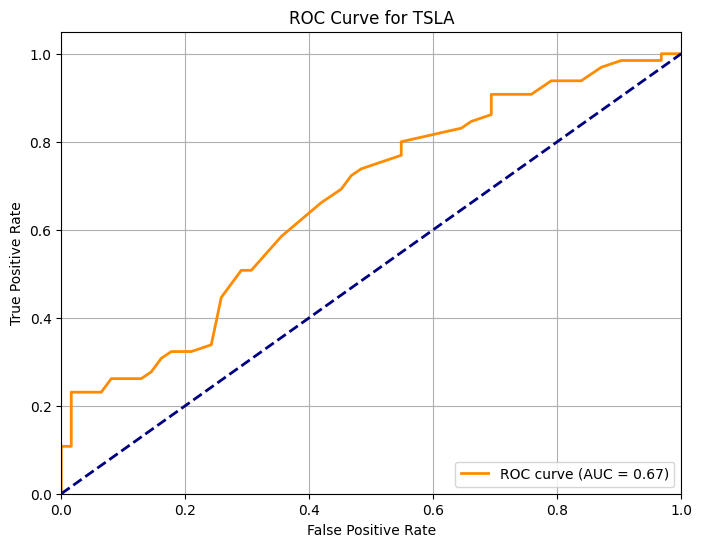

Area Under the ROC Curve (AUC) - TSLA: 0.667

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        62
           1       0.62      0.66      0.64        65

    accuracy                           0.62       127
   macro avg       0.62      0.62      0.62       127
weighted avg       0.62      0.62      0.62       127



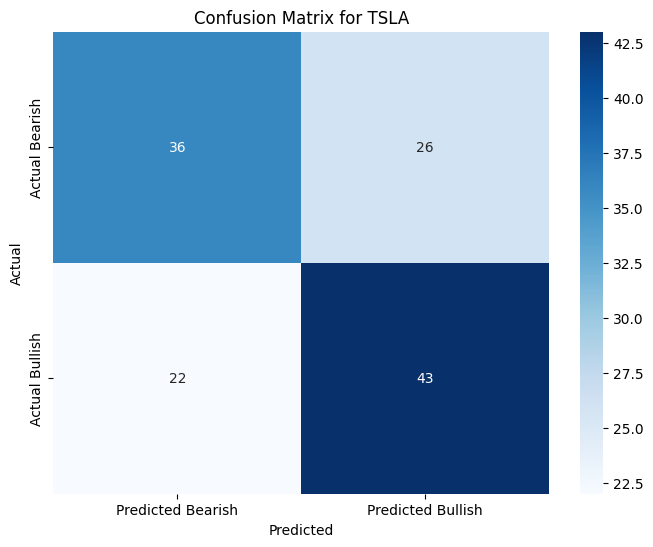

0.6667493796526055


In [25]:
def get_predictions_and_labels(env, q_table):
        y_true = []
        y_pred_proba = []
        
        state = env.reset()
        
        while not env.done:
            state_idx = discretize_state(state)
            q_values = q_table[state_idx, :]
            proba = np.exp(q_values) / np.sum(np.exp(q_values))
            
            current_index = min(env.index - 1, len(env.actual_trend) - 1)
            true_trend = env.actual_trend[current_index % len(env.actual_trend)]
            
            y_true.append(true_trend)
            y_pred_proba.append(proba[1])  # Probability of Bullish (class 1)
            
            state, _, _ = env.step(np.argmax(proba))
        
        return np.array(y_true), np.array(y_pred_proba)

    # Get predictions and true labels
y_true, y_pred_proba = get_predictions_and_labels(env, q_table)
    
    # ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

    # Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {stock}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Area Under the ROC Curve (AUC) - {stock}: {roc_auc:.3f}")

    # Classification Report (Precision, Recall, F1-Score, etc.)
print("\nClassification Report:")
print(classification_report(y_true, np.array(y_pred_proba) >= 0.5))  # Convert probabilities to labels for classification report

    # Confusion Matrix
y_pred = (np.array(y_pred_proba) >= 0.5).astype(int)  # Convert probabilities to binary labels
conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Predicted Bearish', 'Predicted Bullish'],
                yticklabels=['Actual Bearish', 'Actual Bullish'])
plt.title(f'Confusion Matrix for {stock}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(roc_auc)


# Augmented Dataset Prediction

In [27]:
df_augment = pd.read_csv('datasets/augmented/TSLA_augmented.csv')

In [28]:
predicted_trends = []

for i in range(len(df_augment)):
    state = np.array([sentiment_scores[i], predicted_prices[i], volatility_features[i]])
    state_idx = discretize_state(state)
    action = np.argmax(q_table[state_idx, :])
    predicted_trends.append(action)

predicted_trends = np.array(predicted_trends)

In [29]:
accuracy = accuracy_score(actual_trend, predicted_trends)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(actual_trend, predicted_trends)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(actual_trend, predicted_trends)
print("Classification Report:")
print(class_report)

Accuracy: 62.20%
Confusion Matrix:
[[36 26]
 [22 43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60        62
           1       0.62      0.66      0.64        65

    accuracy                           0.62       127
   macro avg       0.62      0.62      0.62       127
weighted avg       0.62      0.62      0.62       127

